## **Starting Model Training**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install imbalanced-learn

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("Cleaned_loan.csv")
df

,Unnamed: 0,person_age,person_education,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,credit_score,previous_loan_defaults_on_file,loan_status
0,0,3.135494,Master,11.183713,RENT,10.047334,PERSONAL,16.02,0.314811,561.0,No,1
1,1,3.091042,High School,9.415971,OWN,6.908755,EDUCATION,11.14,0.076961,504.0,Yes,0
2,2,3.258097,High School,9.428592,MORTGAGE,8.612685,MEDICAL,12.87,0.314811,635.0,No,1
3,3,3.178054,Bachelor,11.286702,RENT,10.047334,MEDICAL,15.23,0.314811,675.0,No,1
4,4,3.218876,Master,11.099469,RENT,10.047334,MEDICAL,14.27,0.314811,586.0,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...
44995,44995,3.332205,Associate,10.778373,RENT,9.615872,MEDICAL,15.66,0.270027,645.0,No,1
44996,44996,3.637586,Associate,11.094390,RENT,9.105091,HOMEIMPROVEMENT,14.07,0.131028,621.0,No,1
44997,44997,3.526361,Associate,10.949806,RENT,7.927324,DEBTCONSOLIDATION,10.02,0.048790,668.0,No,1
44998,44998,3.401197,Bachelor,10.409250,RENT,9.392745,EDUCATION,13.23,0.307485,604.0,No,1


In [4]:
cat_feat = []
num_feat = []
for col in df.columns:
    if df[col].dtype=='object':
        cat_feat.append(col)
    else:
        num_feat.append(col)

In [5]:
cat_feat, num_feat

(['person_education',
  'person_home_ownership',
  'loan_intent',
  'previous_loan_defaults_on_file'],
 ['Unnamed: 0',
  'person_age',
  'person_income',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'credit_score',
  'loan_status'])

In [6]:
y = df['loan_status']
X = df.drop('loan_status',axis=1)

In [7]:
X = X.drop('Unnamed: 0',axis=1)

## **Making numerical and categorical feATURES LIST**

In [8]:
cat_feat = []
num_feat = []
for col in X.columns:
    if X[col].dtype=='object':
        cat_feat.append(col)
    else:
        num_feat.append(col)

cat_feat, num_feat

(['person_education',
  'person_home_ownership',
  'loan_intent',
  'previous_loan_defaults_on_file'],
 ['person_age',
  'person_income',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'credit_score'])

In [9]:
df['previous_loan_defaults_on_file'].value_counts()

previous_loan_defaults_on_file
Yes    22858
No     22142
Name: count, dtype: int64

## **Train Test Split**

In [47]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.2,random_state=42)

In [11]:
# %pip install imbalanced-learn
# import imblearn
# from imblearn.under_sampling import RandomUnderSampler

In [12]:
# res = RandomUnderSampler(random_state=42)
# X_resample,y_resample = res.fit_resample(X_train,y_train)

## **Making Pipeline**

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

onehot_cols = ['person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
ordinal_cols = ['person_education']

ord_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
ohe_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

## **RandomForest Classifier**

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 1. Define your pipeline (as before)
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_feat),
    ('ohe_cat', ohe_categorical_transformer, onehot_cols),
    ('ord_cat', ord_categorical_transformer, ordinal_cols)
])

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 2. Fit the pipeline
# After fitting the pipeline
rf_pipeline.fit(X_train, y_train)

# Get the classifier and feature importances
rf_classifier = rf_pipeline.named_steps['classifier']
importances = rf_classifier.feature_importances_

# Get transformed feature names
feature_names = rf_pipeline.named_steps['preprocess'].get_feature_names_out()

# Adjust importances based on weight_map
weight_map = {
    'num_person_income': 5.0,
    'num_credit_score': 1.5,
    'income_to_loan_ratio': 2.5,
    'ohe_cat_loan_intent_EDUCATION': 0.3
}

for i, name in enumerate(feature_names):
    base_name = name.split('__')[-1]  # Extract base feature name
    if base_name in weight_map:
        importances[i] *= weight_map[base_name]

# Normalize importances
importances /= importances.sum()

# Get top 10 features
top_feature_indices = np.argsort(importances)[-10:]
top_features = [feature_names[i] for i in top_feature_indices]

# Optional: Retrain on top features
X_train_transformed = rf_pipeline.named_steps['preprocess'].transform(X_train)
X_train_top10 = pd.DataFrame(X_train_transformed, columns=feature_names)[top_features]

rf_classifier_top10 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_top10.fit(X_train_top10, y_train)




RandomForestClassifier(random_state=42)

In [67]:
# 1. Preprocess X_test using the same ColumnTransformer
X_test_transformed = rf_pipeline.named_steps['preprocess'].transform(X_test)

# 2. Convert to DataFrame and select the SAME top 10 features
X_test_top10 = pd.DataFrame(X_test_transformed, columns=feature_names)[top_features]

# 3. Now predict using the top-10 model
rf_y_pred = rf_classifier_top10.predict(X_test_top10)

# 4. Generate classification report
rf_report = classification_report(y_test, rf_y_pred, output_dict=True)
pd.DataFrame(rf_report).transpose()

,precision,recall,f1-score,support
0,0.929974,0.960773,0.945123,27991.00000
1,0.844959,0.747159,0.793055,8009.00000
accuracy,0.913250,0.913250,0.913250,0.91325
macro avg,0.887467,0.853966,0.869089,36000.00000
weighted avg,0.911061,0.913250,0.911292,36000.00000


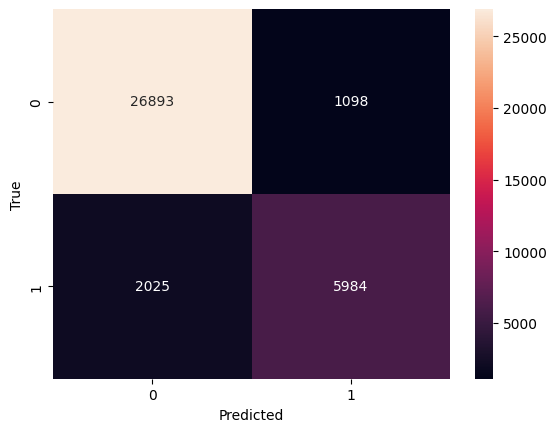

In [57]:
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Grid Search CV with RandomForest**

In [16]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

rf_pipeline = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('classifier',RandomForestClassifier(random_state=42))
])
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['auto', 'sqrt']
}

gs_rf_pipeline = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=2
)

gs_rf_pipeline.fit(X_train,y_train)
gs_rf_y_pred = gs_rf_pipeline.predict(X_test)

gs_rf_report = classification_report(y_test, rf_y_pred, output_dict=True)
pd.DataFrame(gs_rf_report).transpose() 


Fitting 5 folds for each of 48 candidates, totalling 240 fits


,precision,recall,f1-score,support
0,0.936666,0.968490,0.952312,27991.000000
1,0.875035,0.771132,0.819805,8009.000000
accuracy,0.924583,0.924583,0.924583,0.924583
macro avg,0.905851,0.869811,0.886059,36000.000000
weighted avg,0.922955,0.924583,0.922833,36000.000000


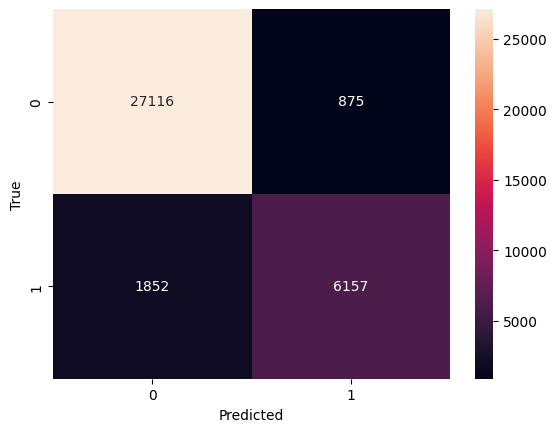

In [17]:
sns.heatmap(confusion_matrix(y_test, gs_rf_y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Logistic REGRESSION**

In [18]:
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings("ignore")

lr_pipeline = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('classifier',LogisticRegression(max_iter=100,random_state=42,class_weight='balanced'))
])

lr_pipeline.fit(X_train,y_train)
lr_y_pred = lr_pipeline.predict(X_test)

lr_report = classification_report(y_test, lr_y_pred, output_dict=True)
pd.DataFrame(lr_report).transpose() 

,precision,recall,f1-score,support
0,0.973941,0.823836,0.892622,27991.000000
1,0.599854,0.922962,0.727130,8009.000000
accuracy,0.845889,0.845889,0.845889,0.845889
macro avg,0.786897,0.873399,0.809876,36000.000000
weighted avg,0.890717,0.845889,0.855805,36000.000000


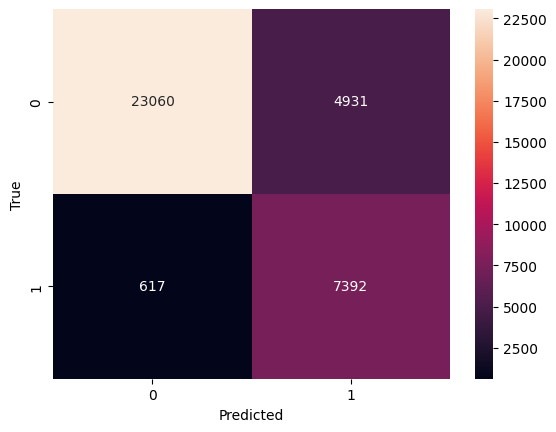

In [19]:
sns.heatmap(confusion_matrix(y_test, lr_y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##  **Decision Tree Classifier**

In [20]:
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings("ignore")

dt_pipeline = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('classifier',DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5))
])

dt_pipeline.fit(X_train,y_train)
dt_y_pred = dt_pipeline.predict(X_test)

dt_report = classification_report(y_test, dt_y_pred, output_dict=True)
pd.DataFrame(dt_report).transpose()



,precision,recall,f1-score,support
0,0.916813,0.971741,0.943478,27991.000000
1,0.875079,0.691847,0.772749,8009.000000
accuracy,0.909472,0.909472,0.909472,0.909472
macro avg,0.895946,0.831794,0.858114,36000.000000
weighted avg,0.907528,0.909472,0.905496,36000.000000


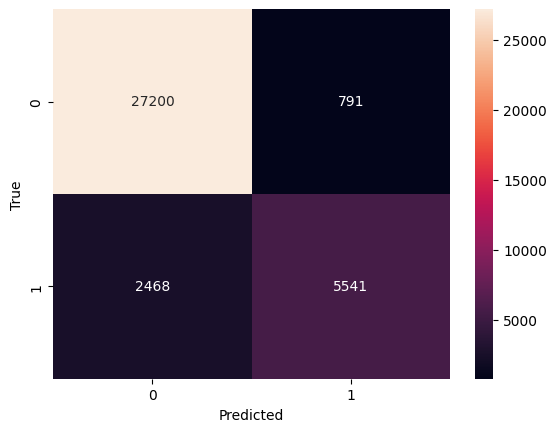

In [21]:
sns.heatmap(confusion_matrix(y_test, dt_y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **XG BOOST**

In [22]:
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")

xgb_pipeline = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('classifier',XGBClassifier())
])

xgb_pipeline.fit(X_train,y_train)
xgb_y_pred = xgb_pipeline.predict(X_test)

xgb_report = classification_report(y_test, xgb_y_pred, output_dict=True)
pd.DataFrame(dt_report).transpose()

,precision,recall,f1-score,support
0,0.916813,0.971741,0.943478,27991.000000
1,0.875079,0.691847,0.772749,8009.000000
accuracy,0.909472,0.909472,0.909472,0.909472
macro avg,0.895946,0.831794,0.858114,36000.000000
weighted avg,0.907528,0.909472,0.905496,36000.000000


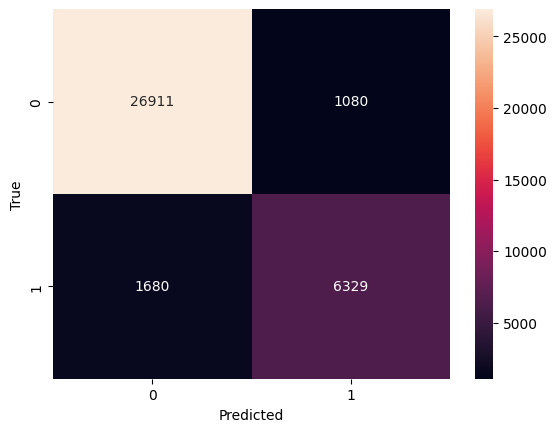

In [23]:
sns.heatmap(confusion_matrix(y_test, xgb_y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Prediction By different MOdels**

In [65]:
# making prediction by each model

new_data = pd.DataFrame({
    'person_age': [23.0],
    'person_education': ['Bachelor'],
    'person_income': [7],
    'person_home_ownership': ['RENT'],
    'loan_amnt': [35000.0],
    'loan_intent': ['EDUCATION'],
    'loan_int_rate': [7.9],
    'loan_percent_income': [0.24],
    'credit_score': [663.0],
    'previous_loan_defaults_on_file': ['No']
})
log_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_percent_income']

for col in log_cols:
    new_data[col] = np.log1p(new_data[col])

rf_prediction = rf_pipeline.predict(new_data)
if rf_prediction == 0:
    print("Prediction By Random Forest: [High Risk]")
else:
    print("Prediction By Random Forest: [Low Risk]")

gs_rf_prediction = gs_rf_pipeline.predict(new_data)
if gs_rf_prediction == 0:
    print("Prediction By GSCV Random Forest: [High Risk]")
else:
    print("Prediction By GSCV Random Forest: [Low Risk]")

dt_prediction = dt_pipeline.predict(new_data)
if dt_prediction == 0:
    print("Prediction By Decision Tree: [High Risk]")
else:
    print("Prediction By Decision Tree: [Low Risk]")

lr_prediction = lr_pipeline.predict(new_data)
if lr_prediction == 0:
    print("Prediction By Logistic Regression: [High Risk]")
else:
    print("Prediction By Logistic Regression: [Low Risk]")

Prediction By Random Forest: [Low Risk]
Prediction By GSCV Random Forest: [Low Risk]
Prediction By Decision Tree: [Low Risk]
Prediction By Logistic Regression: [Low Risk]


## **Model Export**

In [61]:
import joblib


joblib.dump(rf_pipeline, 'rf_model_pipeline.pkl')

['rf_model_pipeline.pkl']

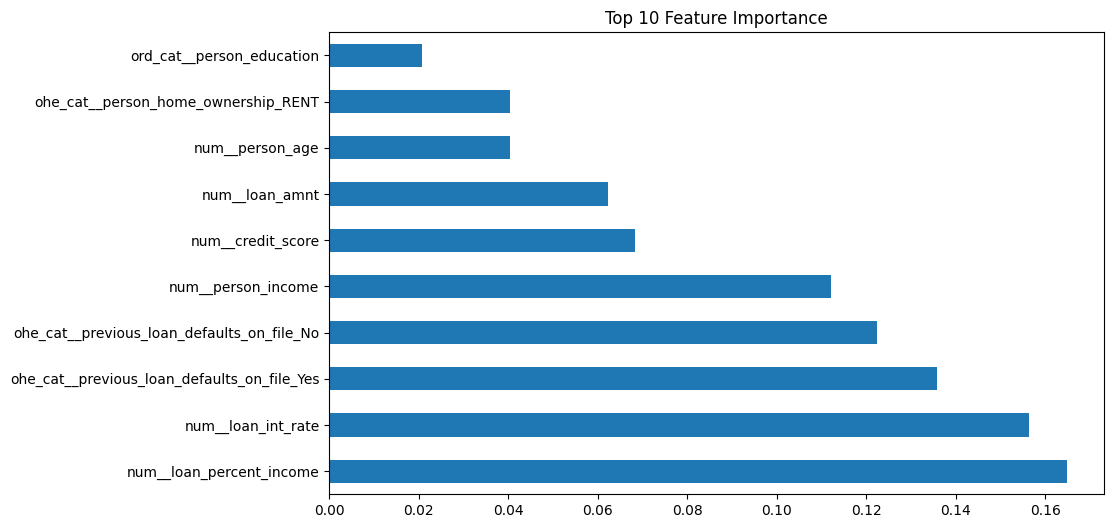

In [68]:
# Get top 10 features AND their importances
top_feature_indices = np.argsort(importances)[-10:]
top_features = [feature_names[i] for i in top_feature_indices]
top_importances = [importances[i] for i in top_feature_indices]

# Create Series with matching lengths
feat_imp = pd.Series(top_importances, index=top_features).sort_values(ascending=False)

# Plot
feat_imp.plot(kind='barh', figsize=(10, 6), title="Top 10 Feature Importance")
plt.show()